# MRS wavelength calibration reference point determination
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven), with updates from Alvaro Labiano (CAB)  
Creation date 7th October 2018  

### > Import modules

In [1]:
import funcs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [2]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"
FilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

### > Give analysis inputs

In [3]:
# inputs
band = '4C'                     # spectral band under investigation
lamblower,lambupper = funcs.mrs_aux(band)[3] # nominal wavelength range of mrs band
islice    = 6                  # slice number (equivalent to beta position)
alpha_pos = 0.                  # along-slice position, [arcsec]

## Start analysis

A reference wavelength/pixel pair is determined using the long-wave-pass (SWP) filter transmission. By comparing the transmission of the filter determined from the lab and with the MRS, a reference wavelength can be matched to a reference pixel on the MRS detector. Let's look at the lab and MRS SWP filter transmission.

During commissioning the reference point will be obtained from the spectral lines of a celestial calibrator.

### > Import filter transmission data

<IPython.core.display.Javascript object>


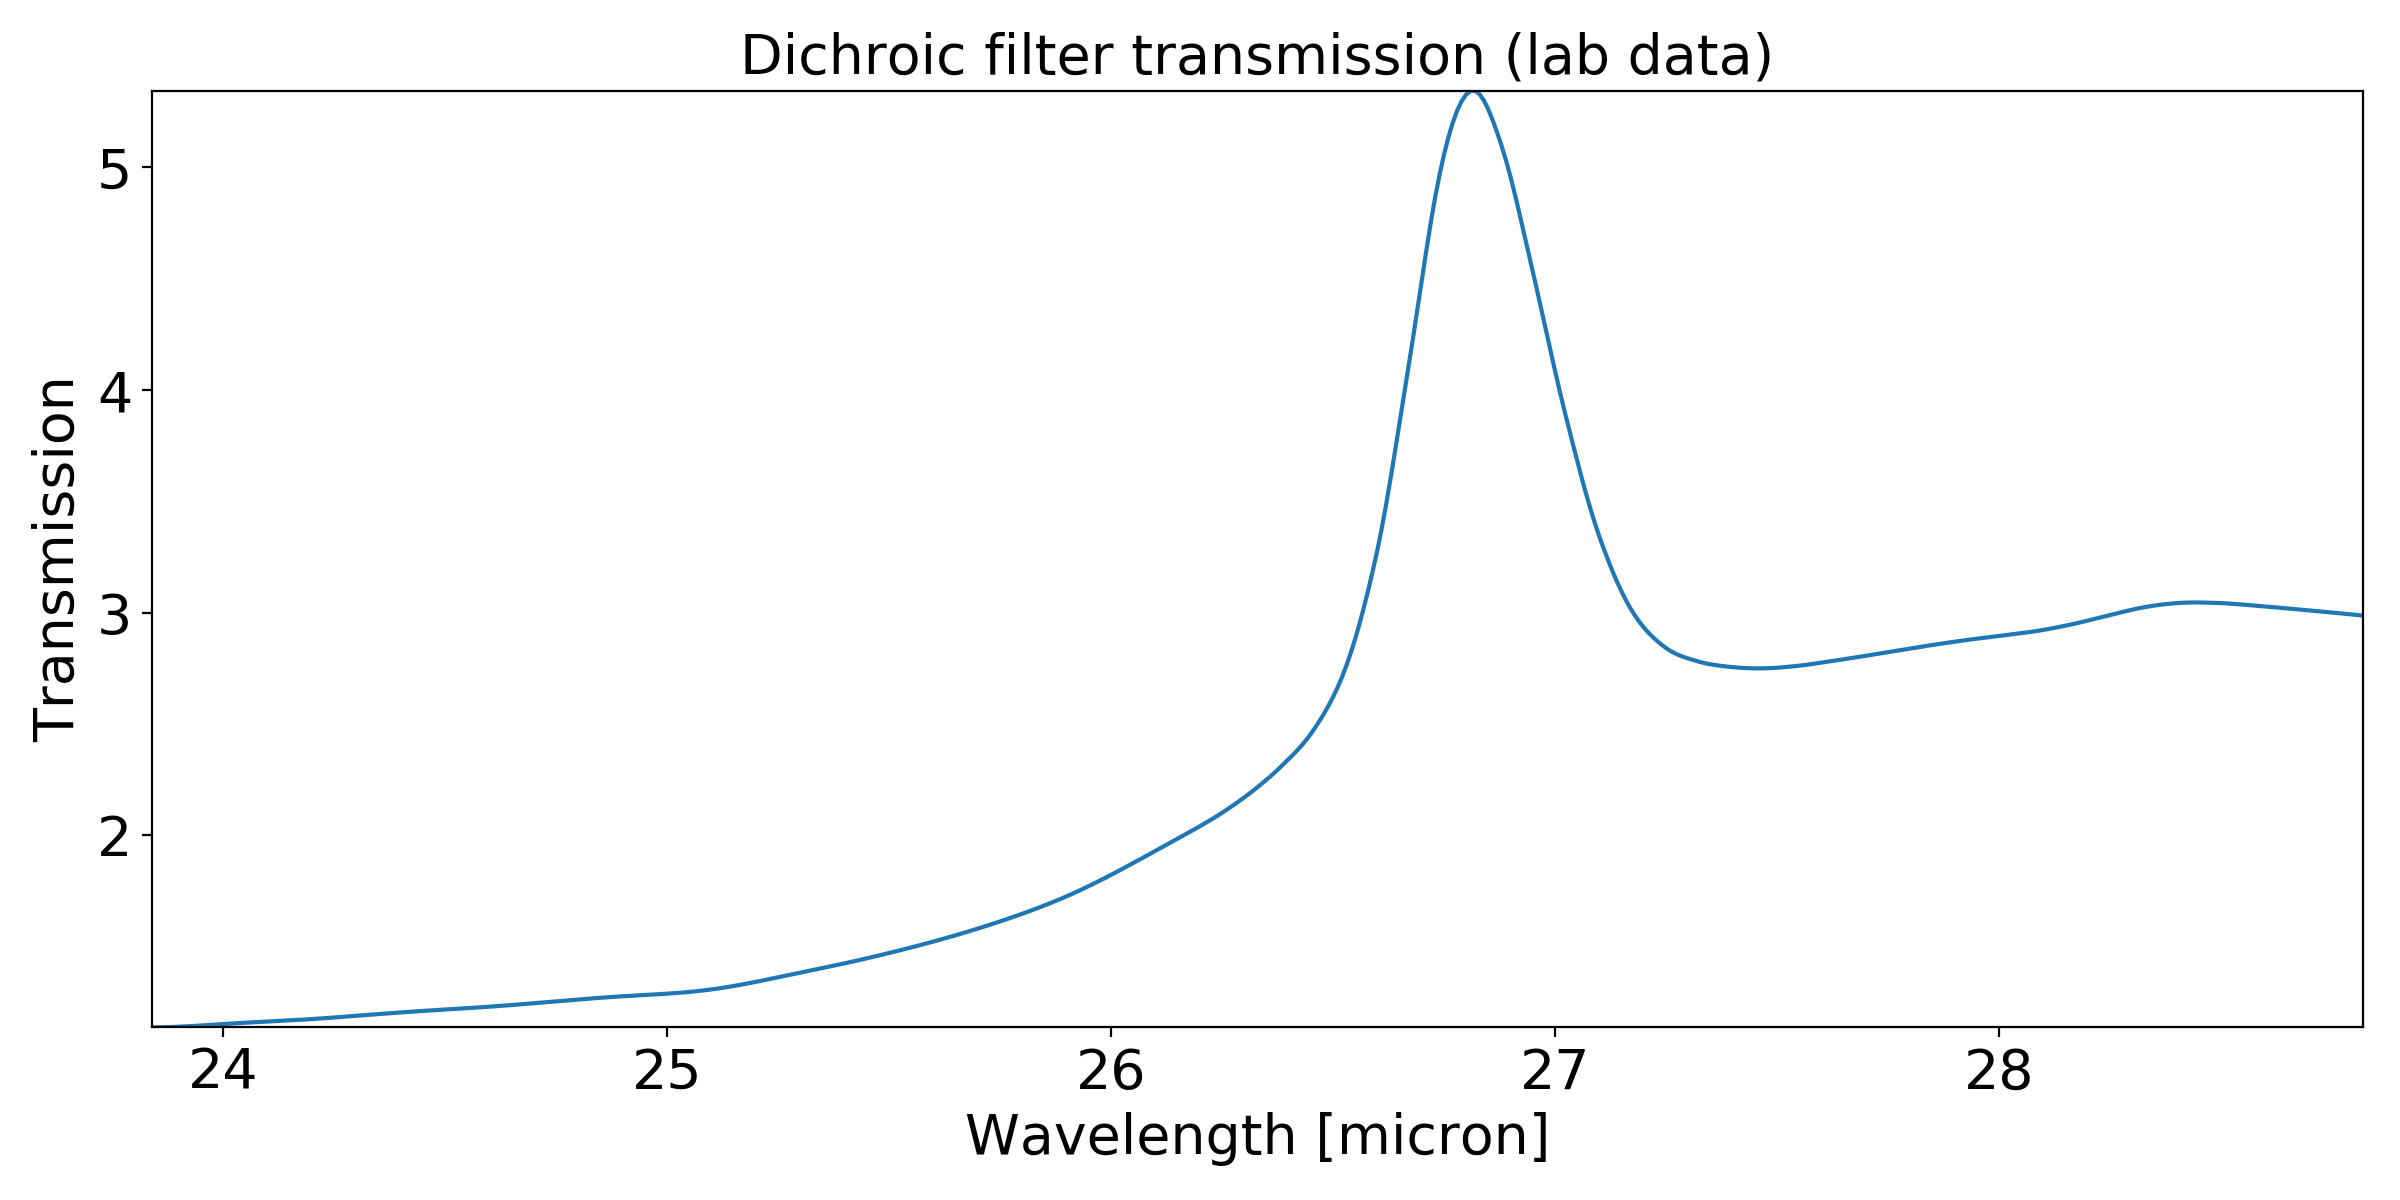

In [4]:
usedfilter,filter_wave,filter_transm = funcs.filter_transmission(band,datapath=FilterTransmDir,verbose=True)

# plot transmissions
plt.figure(figsize=(12,6))
plt.plot(filter_wave,filter_transm)
plt.xlim(lamblower,lambupper)
plt.ylim(min(filter_transm),max(filter_transm))
plt.title('{} filter transmission (lab data)'.format(usedfilter),fontsize=20)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

## > Import MRS observations of filter

<IPython.core.display.Javascript object>


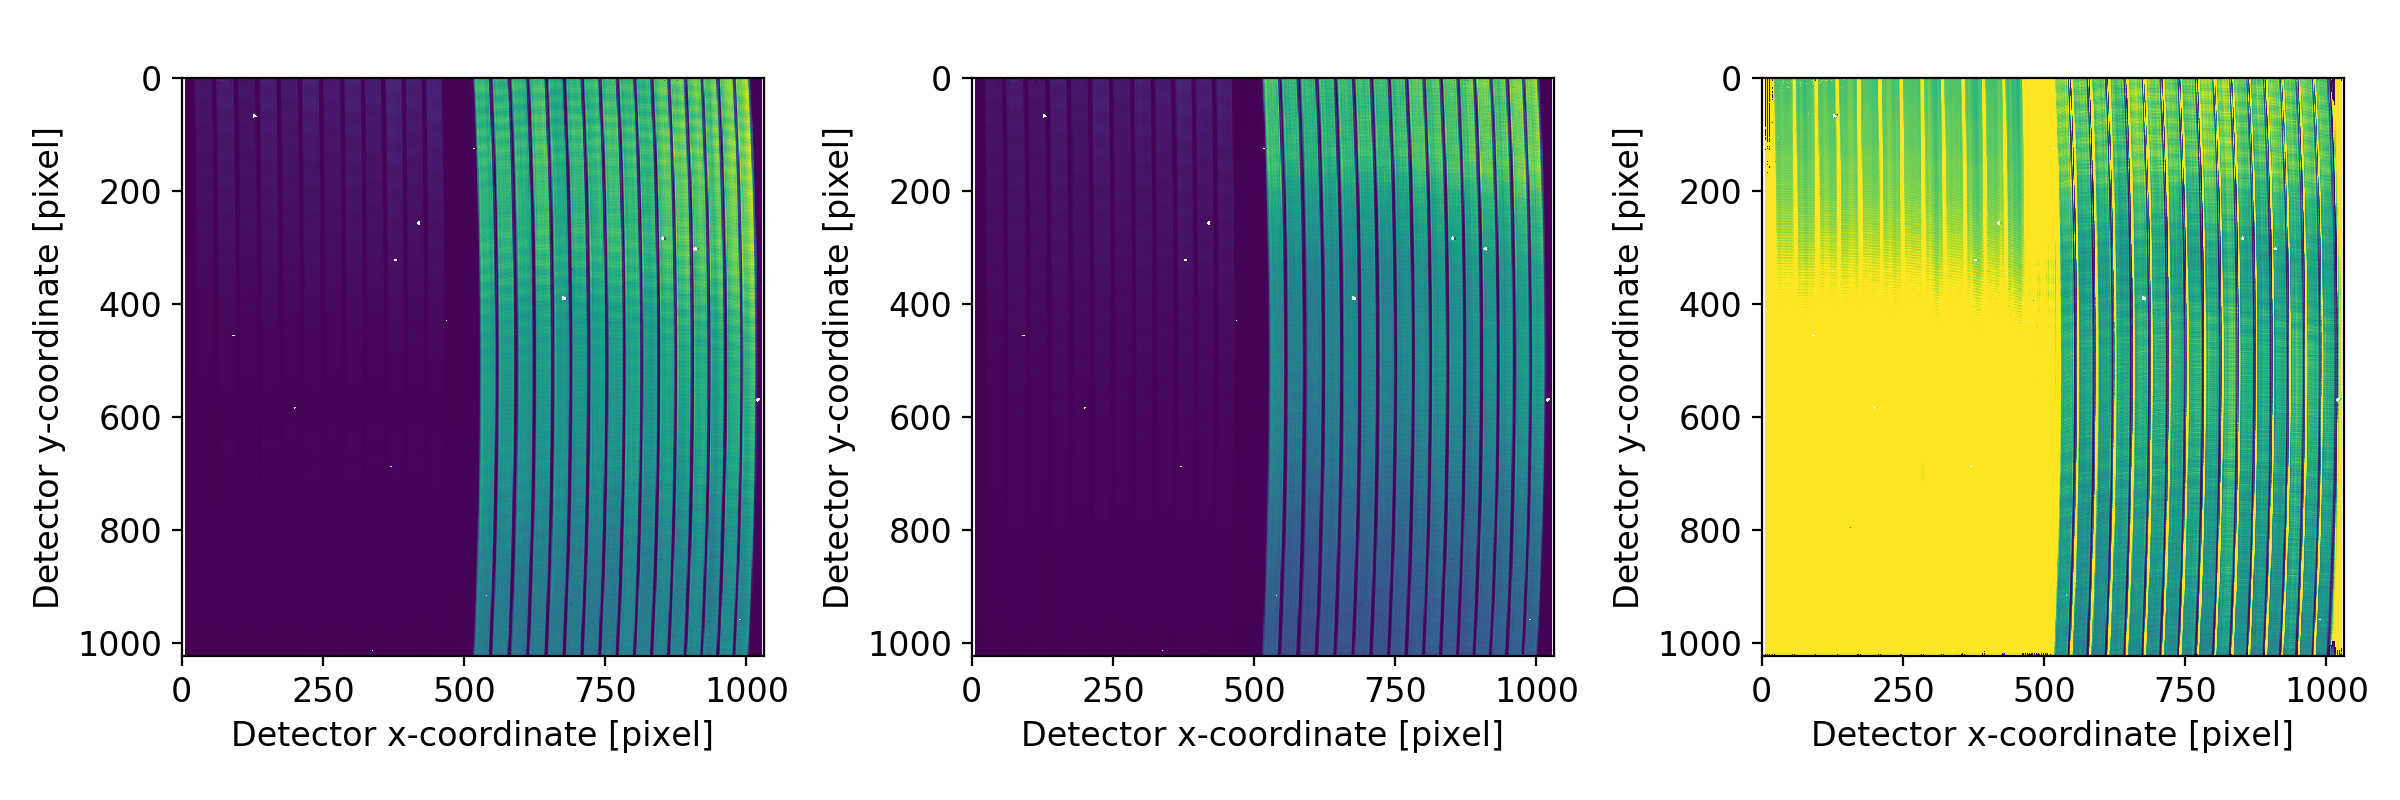

In [5]:
usedfilter,source_img1,source_img2,mrs_transmission_img = funcs.mrs_filter_transmission(band,datapath=lvl2path)
if band[0] in ['3','4']:
    # The wavecal analysis of channels 3 and 4 will be inverted; 
    # this is to by-pass the issue that the lambdaMap of channel 3 and 4 are in fact inverted (pix0->1024 yields decreasing wavelengths, as opposed to channels 1 and 2 that yield increasing wavelengths)
    source_img1,source_img2,mrs_transmission_img = np.flipud(source_img1),np.flipud(source_img2),np.flipud(mrs_transmission_img)

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(source_img1)
axs[1].imshow(source_img2)
axs[2].imshow(mrs_transmission_img,vmin=0,vmax=1.4)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
if usedfilter in ['SWP','LWP']:
    axs[0].set_title('{} filter observation'.format(usedfilter),fontsize=12)
    axs[1].set_title('Extended source observation',fontsize=12)
    axs[2].set_title('{} filter transmission'.format(usedfilter),fontsize=12)
if band == '2A':
    axs[0].set_title('2AxB observation',fontsize=12)
    axs[1].set_title('1A/2A observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
elif band == '2B':
    axs[0].set_title('2BxC observation',fontsize=12)
    axs[1].set_title('1B/2B observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
plt.tight_layout()

## > Perform wavelength calibration analysis on selected position

In [6]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

if band[0] in ['3','4']:
    sliceMap  = np.flipud(sliceMap)
    lambdaMap = np.flipud(lambdaMap)
    alphaMap  = np.flipud(alphaMap)

<IPython.core.display.Javascript object>


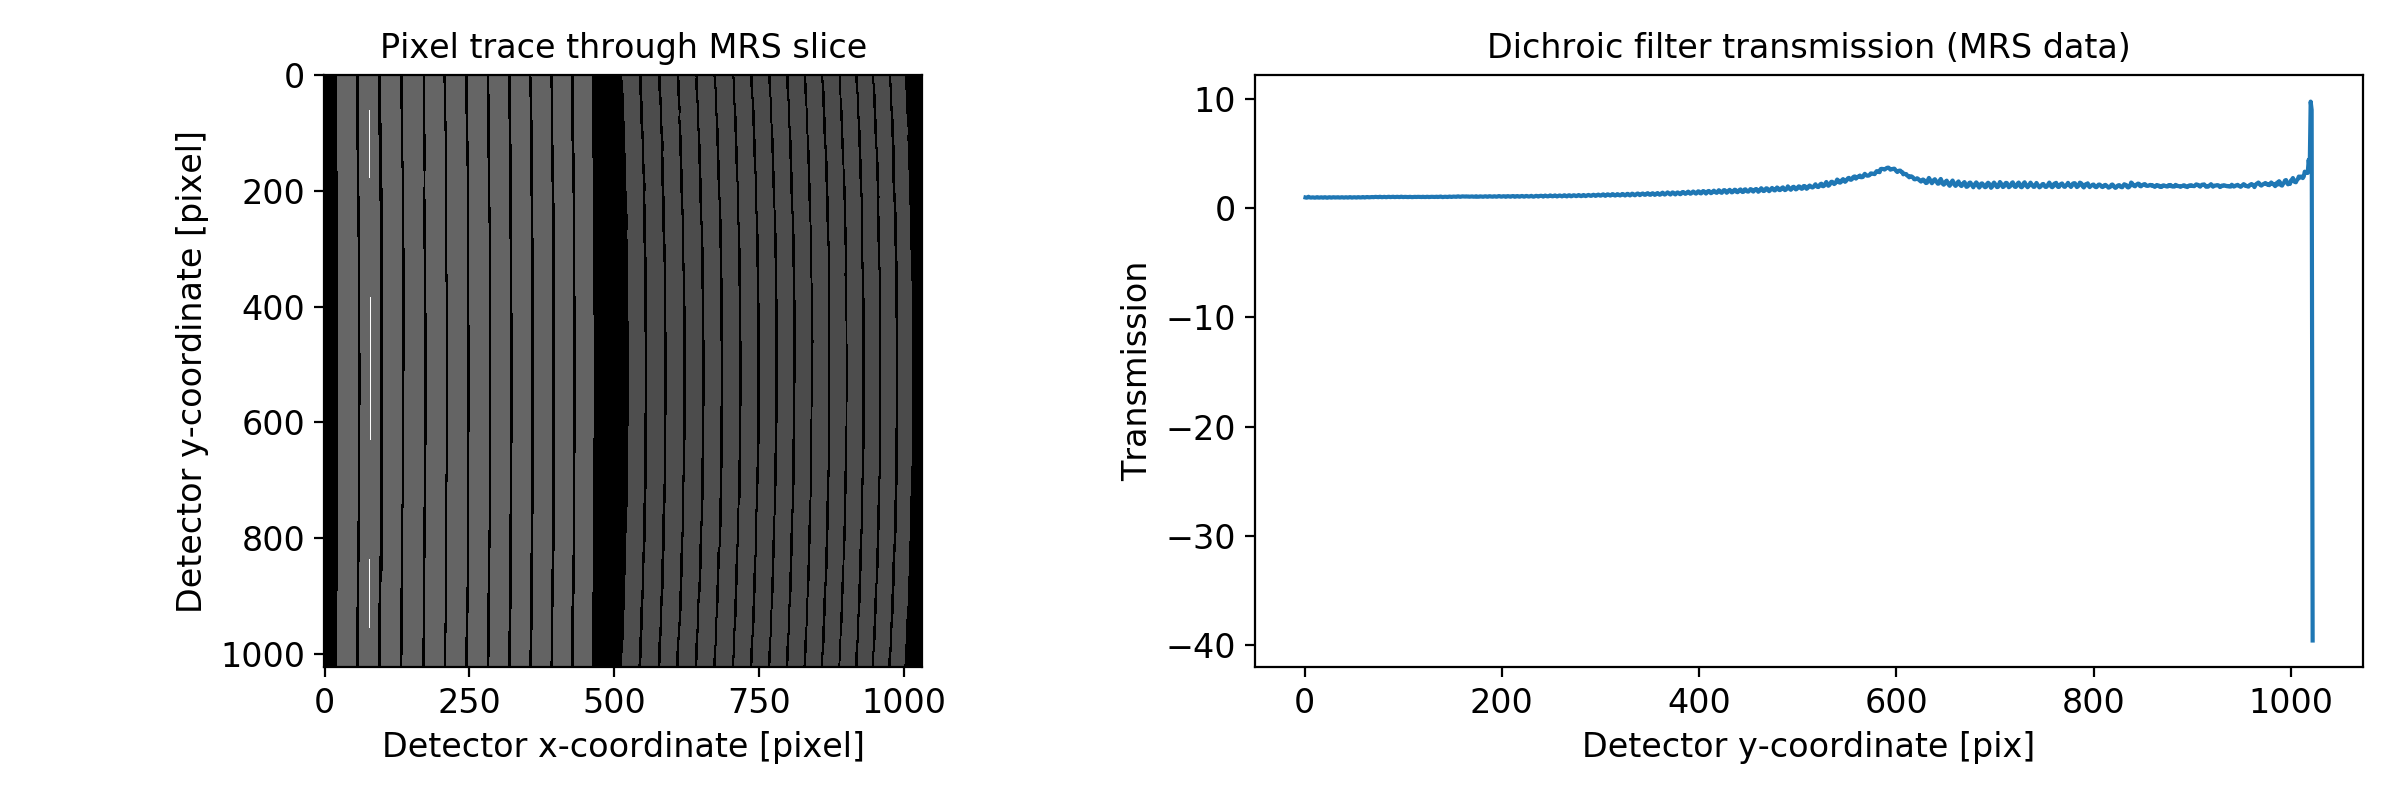

In [7]:
# take pixel trace along specified slice, specified alpha position
## ******* AL: Shall we use interpolation between closest alpha values? <-- This should result in a pixel to sub-pixel order improvement on the determination of the wavelength-pixel reference
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)

# plot trace
valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(sliceMap,cmap='gray')
axs[0].imshow(valid_img,alpha=0.6,cmap='gray')
axs[0].set_title('Pixel trace through MRS slice',fontsize=12)
axs[0].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
axs[0].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
axs[1].plot(mrs_transmission_img[ypos,xpos])
axs[1].set_title('{} filter transmission (MRS data)'.format(usedfilter),fontsize=12)
axs[1].set_xlabel('Detector y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('Transmission',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

### > Yannis fit of the reference point
The result of the following analysis is the definition of a reference wavelength/pixel pair.

592.703028063


<IPython.core.display.Javascript object>


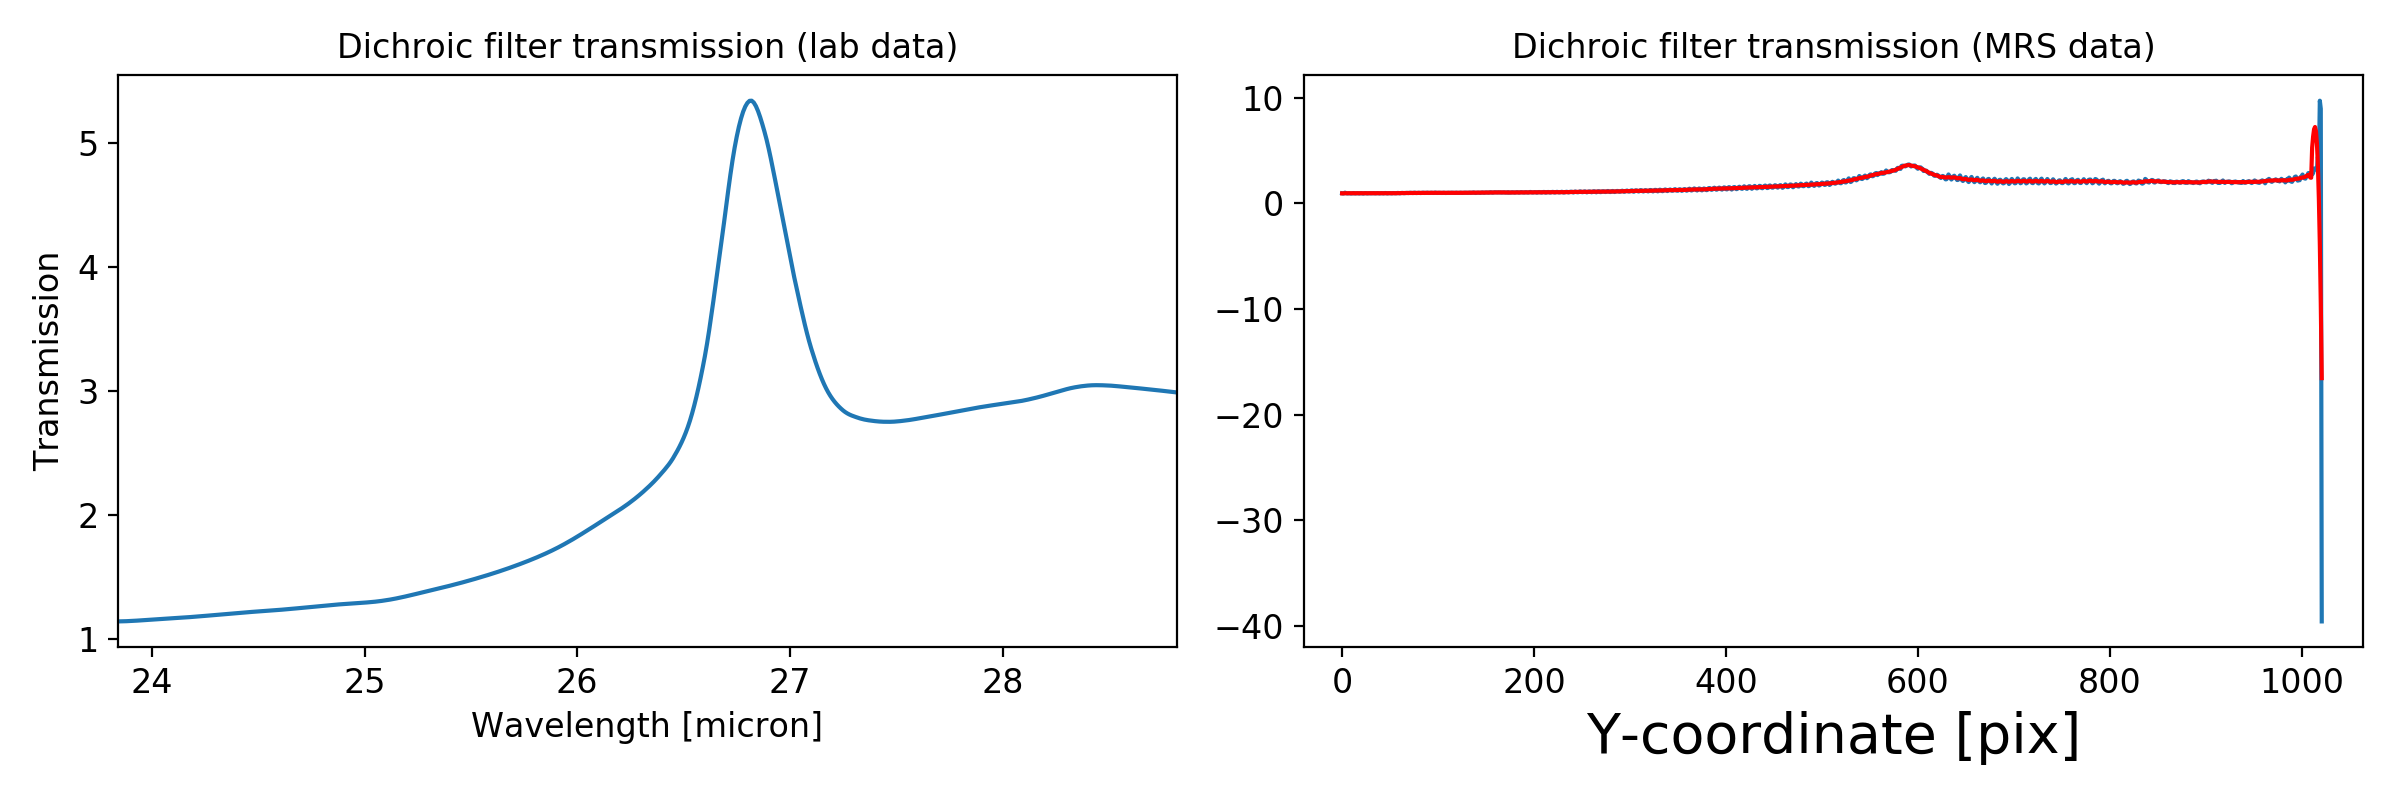

<IPython.core.display.Javascript object>


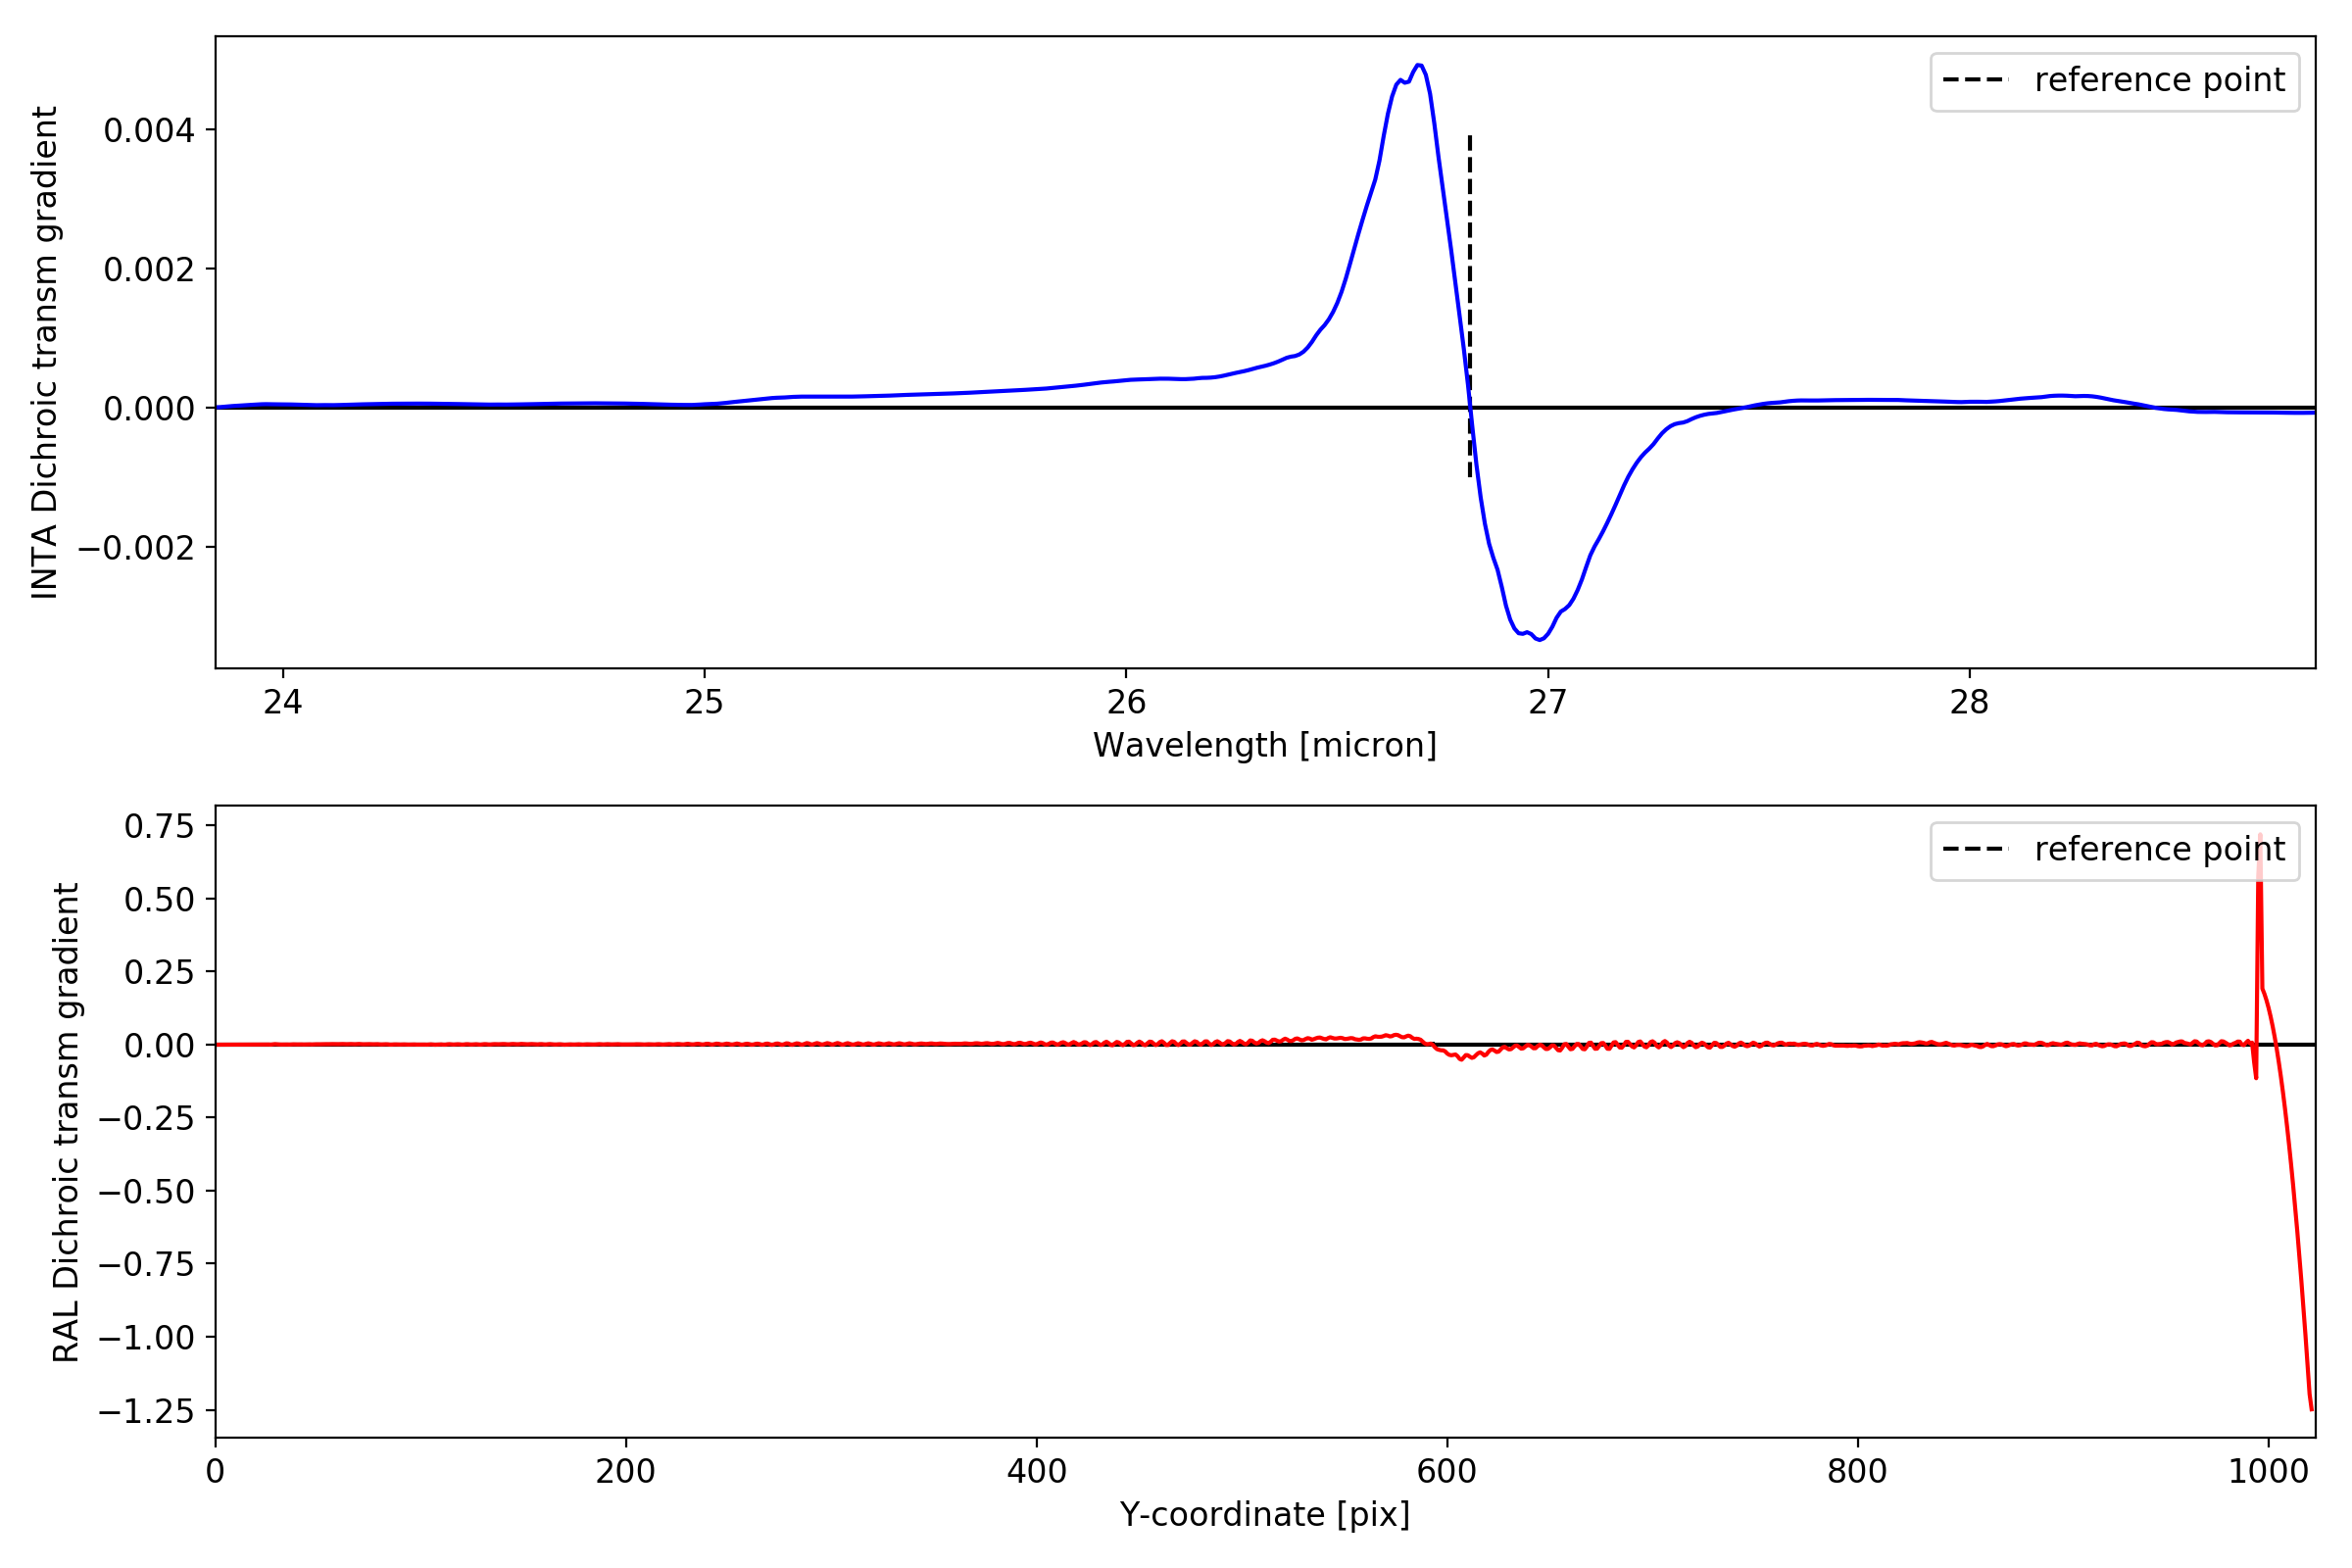

Reference wavelength: 26.816 micron
Reference pixel: 431.297 pix


In [8]:
# load spectrum from desired location and carry-out analysis
mrs_transmission = mrs_transmission_img[ypos,xpos]
# determine cut-off wavelength/pixel pair
cutofflamb,cutoffpix = funcs.get_reference_point(band,filter_wave,filter_transm,mrs_transmission,plot=True)

print 'Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'Reference pixel: {} pix'.format(round(cutoffpix,3))

# wavelength maps of channels 3 and 4 are inverted!
if band[0] in ['3','4']:
    cutoffpix  = len(mrs_transmission)-cutoffpix
    print 'Flipped reference pixel: {} pix'.format(round(cutoffpix,3))

### > Alvaro's fit of the reference point

In [9]:
# ## BASED ON 1C_comparafiltros_lam_to_coordy_allcols.py

# from scipy import interpolate
# from scipy import optimize
# from scipy import stats

# normaliz = 1 # 100    
# guess = [150, 800, 1.03]
# bound_val = 0 #np.nan

# # Fit region
# fmpixlims = [5,400]
# fmwavlims = [6.515,6.9]  #values used for original wavecal, using zemax wavelengths

# intawavlims = [fmwavlims[0]-0.08,fmwavlims[1]-0.05]
# # Fit centers
# lam_ref_val = 6.626905235  #(taken from SWP_INTA.dat) for 0.45815491
# flx_ref_val = 0.45815491

# ### FM data
# sci_fm_data = Swp_transmission_img[ypos,xpos]
# #sci_fm_data[np.isnan(sci_fm_data)] = 0   ## NANS????
# yFM_orig = sci_fm_data
# xFM_pixl = np.array(range(1,yFM_orig.size+1))        # In pixels
# # print sci_fm_data.shape, yFM_orig.shape, xFM_pixl.shape

# # Cut the spectra to the region of interest:
# inds_xFM = np.arange(fmpixlims[0],fmpixlims[1])   #inds_xFM = np.where((xFM_orig > fmwavlims[0]) & (xFM_orig < fmwavlims[1]))
# xFM_cut = xFM_pixl[inds_xFM]
# yFM_cut = yFM_orig[inds_xFM]

# # Use only rows of FM where flux is NOT nan:
# nans_yfm = np.isnan(yFM_cut)
# inds_yfm = np.where(nans_yfm == False)
# xFM = xFM_cut[inds_yfm]
# yFM = yFM_cut[inds_yfm]


# ### INTA data
# wINTA_orig = SWPwave
# yINTA_orig = SWPtransm
# inds_winta = np.where((wINTA_orig > intawavlims[0]) & (wINTA_orig < intawavlims[1]))
# wINTA = wINTA_orig[inds_winta]
# yINTA = yINTA_orig[inds_winta]             


# yINTA = yINTA/normaliz

# # Plot original data
# fig,axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].plot(wINTA,yINTA)
# axs[0].set_xlim(intawavlims[0]-0.1,intawavlims[1]+0.1)
# axs[0].tick_params(axis='both',labelsize=20)
# axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
# axs[0].set_ylabel('Transmission',fontsize=20)
# axs[0].set_title('SWP - INTA data')
# axs[1].plot(xFM,yFM)
# #axs[1].plot(spl(np.arange(len(sci_fm_data))),'r')
# axs[1].set_xlim(fmpixlims[0]-10,fmpixlims[1]+10)
# axs[1].set_xlabel('Y-coordinate [pix]',fontsize=20)
# axs[1].tick_params(axis='both',labelsize=20)
# axs[1].set_title('SWP - FM data')
# plt.tight_layout()


# ## Fits one curve with the other
# def FM_T2(zz,a,b,c):  # analoga a f2, en su ejemplo
#     xINTAp = a + (wINTA - lam_ref_val) * b  # nuevo eje de lambdas del FM  
# #     print a,b, c
#     #print "xFMp=" ,xFMp
#     yINTAinterpol = interpolate.interp1d(xINTAp,yINTA,bounds_error=False,fill_value=bound_val,kind='cubic')
#     yINTAp = yINTAinterpol(zz) 
# #     print zz.size, xINTAp.size, yINTAp.size # print size(zz), size(xINTAp), size(yINTAp)
# #     print "MINFM, MAXFM, MININTA, MAXINTA =", min(xFM), max(xFM), min(wINTA), max(wINTA) #, ifusli+xcol   ######
#     y_fut =  yINTAp * c # +d
#     return y_fut        

                    
# params, params_covariance = optimize.curve_fit(FM_T2,xFM, yFM, guess)
# print "covar", params_covariance
# if str(params_covariance) == 'inf':
#     print "params", params[0], '+/-', str(params_covariance), params[1], '+/-', str(params_covariance), params[2], '+/-', str(params_covariance)
#     params_stddev = ['inf','inf','inf']
#     tit2 = 'inf'
#     tit4 = 'inf'
#     tit6 = 'inf'
# else:
#     print "params", params[0], '+/-', params_covariance[0,0]**0.5, params[1], '+/-', params_covariance[1,1]**0.5, params[2], '+/-', params_covariance[2,2]**0.5
#     # matrix of fit covariances, (the diagonals of which are the squares of the 1 sigma uncertainties on the fit coefficients)
#     params_stddev = [params_covariance[0,0]**0.5,params_covariance[1,1]**0.5, params_covariance[2,2]**0.5]
#     tit2 = str("%.5f" % params_stddev[0])
#     tit4 = str("%.3e" % params_stddev[1])
#     tit6 = str("%.5f" % params_stddev[2])

# new_xINTA = params[0] + params[1] * (wINTA - lam_ref_val )
# new_yINTA = yINTA * params[2]

# print params[0] + params[1] * (np.array([6.559527714,6.626905235 ,6.677796327]) - lam_ref_val) #+ params[3] * (np.array([7.65,8.06,8.17]) - lam_ref_val)**2. 
# print params[2]*(np.array([0.201256,0.45815491,0.70766796]))


In [10]:
# #Plot result 
# plot_xlims = [-50,350]
# plot_ylims = [0,1]
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(xFM, yFM, 'b-', label="FM data")
# ax.plot(guess[0] + guess[1] * (wINTA - lam_ref_val), yINTA*guess[2], 'g', ls='dotted', label="Initial guess")
# ax.plot(xFM, FM_T2(xFM, *params), 'r', label="resulting fit")
# #ax.set_title(tit0)
# ax.set_xlim(plot_xlims[0],plot_xlims[1])
# ax.set_ylim(plot_ylims[0],plot_ylims[1])
# ax.set_yticks(np.arange(0,11)*0.1)
# ax.legend(loc=4)
# ax.set_xlabel('Y-pixel')
# ax.set_ylabel('Throughput')

# print "\n"
# print lam_ref_val, params[0], "Alvaro's reference point"
# pix_INTA = params[0] + params[1] * (wINTA - lam_ref_val )
# print pix_INTA[169],wINTA[169], "Yannis reference pixel with Alvaro's conversion"
# pix_Yannis = params[0] + params[1] * (cutofflamb - lam_ref_val )
# print cutofflamb, pix_Yannis, "Yannis reference wavelength using Alvaro's conversion"

In [11]:
print 'YANNIS Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'YANNIS Reference pixel: {} pix'.format(round(cutoffpix,3))

yan_ref = np.array([cutofflamb,cutoffpix])
# alo_ref = np.array([lam_ref_val, params[0]])
# print yan_ref
# print alo_ref

YANNIS Reference wavelength: 26.816 micron
YANNIS Reference pixel: 431.297 pix


In [12]:
# save output
save_file = open('data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(islice)+'_alpha'+str(alpha_pos)+'_refpoint_'+user+'.txt', 'w')
save_file.write('# Band '+str(band)+'   Filter {}   RefSlice '.format(usedfilter)+str(islice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(islice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Reference Wavelength  Reference pixel (pix)\n')

if user == 'yannis':
    save_file.write(str(yan_ref[0])+'  '+str(yan_ref[1]))
elif user == 'alvaro':
    save_file.write(str(alo_ref[0])+'  '+str(alo_ref[1]))
save_file.close()

## IDEA FOR UNCERTAINTIES:

Run mMontecarlo on Alvaro's fit (Can it be done for Yannis's too? 

The idea is to create many (1000?) curves varying the throughput and wavelength  (or pixel) data points within their error bars (half a pixel?), rerun the fit for all of them, and check the variations